# ECG
Load data


In [10]:
import os
import numpy as np
import pandas as pd

# Max number of data points per heartbeat
max_length = 75
limit_of_samples = 100

# Define paths
normal_dir = './ecg/normal'
abnormal_dir = './ecg/abnormal'
# Labels
normal = 0
abnormal = 1


def load_data_from_directory(directory, label, mode='constant', limit=-1):
    data_list = []

    for filename in os.listdir(directory):
        if not filename.endswith('0') and not filename.endswith('1'):
            continue
        if limit == 0:
            break
        limit -= 1
        path = os.path.join(directory, filename)
        heartbeat = pd.read_csv(path, delimiter='\s+', header=None)[1]

        if len(heartbeat) < max_length:
            if mode == 'constant':
                heartbeat = np.pad(heartbeat, (0, max_length - len(heartbeat)), mode='constant',
                                   constant_values=0)
            elif mode == 'mean':
                heartbeat = np.pad(heartbeat, (0, max_length - len(heartbeat)), mode='mean')
        else:
            heartbeat = heartbeat[:max_length]
        heartbeat = {k: v for k, v in enumerate(heartbeat)}
        heartbeat['label'] = label
        data_list.append(heartbeat)

    return data_list


normal_data = load_data_from_directory(normal_dir, normal, limit=limit_of_samples)
abnormal_data = load_data_from_directory(abnormal_dir, abnormal, limit=limit_of_samples)
df = pd.DataFrame(normal_data + abnormal_data).sample(frac=1)
df

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,label
30,-52,-180,-68,59,72,162,210,286,356,350,...,10,18,8,14,10,10,12,10,12,0
173,162,220,298,264,136,12,-2,-20,-16,-24,...,-46,-148,-178,-51,-8,36,0,0,0,1
140,128,255,324,266,138,10,98,140,126,148,...,6,-8,-2,-2,-4,-14,-6,-6,-10,1
75,4,-66,-194,-154,-27,4,120,180,244,352,...,8,6,8,0,10,18,26,32,34,0
60,26,8,80,-14,-24,-92,-106,-120,-114,-104,...,40,86,58,50,76,98,100,102,94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,58,86,148,275,338,278,150,22,-34,-12,...,0,0,0,0,0,0,0,0,0,1
103,-58,-186,-108,19,10,78,126,184,282,274,...,16,18,22,14,18,18,12,18,22,1
99,198,262,152,24,-86,-74,-68,-118,-64,-62,...,0,0,0,0,0,0,0,0,0,0
116,-6,-14,-98,-98,29,2,64,126,182,252,...,0,0,0,0,0,0,0,0,0,1


# Split into Train/Test Set

In [11]:
from sklearn.model_selection import train_test_split

n = 0.3
random_seed = 42
np.random.seed(random_seed)

X = df.iloc[:, :75]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n, random_state=random_seed)

Resample via smote, because abnormal is underrepresented

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

Rescale features X

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Epoch 1/150
15/15 [==============================] - 1s 2ms/step - loss: 0.6628 - accuracy: 0.6216 - precision_2: 0.9091 - recall_2: 0.2703    
Epoch 2/150
15/15 [==============================] - 0s 1ms/step - loss: 0.5331 - accuracy: 0.7635 - precision_2: 0.8000 - recall_2: 0.7027
Epoch 3/150
15/15 [==============================] - 0s 2ms/step - loss: 0.4676 - accuracy: 0.8176 - precision_2: 0.7901 - recall_2: 0.8649
Epoch 4/150
15/15 [==============================] - 0s 2ms/step - loss: 0.4171 - accuracy: 0.8514 - precision_2: 0.8333 - recall_2: 0.8784
Epoch 5/150
15/15 [==============================] - 0s 1ms/step - loss: 0.3833 - accuracy: 0.8649 - precision_2: 0.8462 - recall_2: 0.8919
Epoch 6/150
15/15 [==============================] - 0s 1ms/step - loss: 0.3530 - accuracy: 0.8919 - precision_2: 0.8625 - recall_2: 0.9324
Epoch 7/150
15/15 [==============================] - 0s 1ms/step - loss: 0.3223 - accuracy: 0.8851 - precision_2: 0.8701 - recall_2: 0.9054
Epoch 8/150
15/1

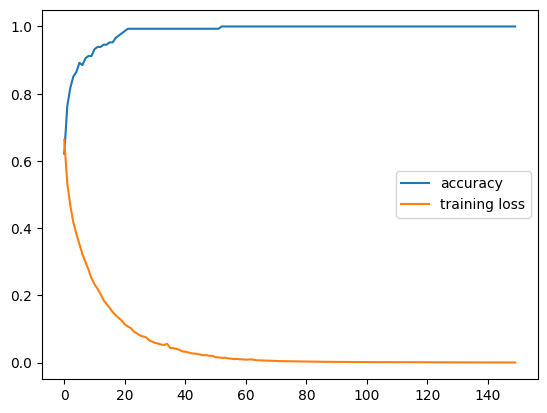

2/2 [==============================] - 0s 4ms/step - loss: 1.4479 - accuracy: 0.8000 - precision_2: 0.7750 - recall_2: 0.9118
Accuracy on testing data: 80.00
Precision on testing data: 77.50
Recall on testing data: 91.18


In [23]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras import metrics

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(64, activation='relu', input_shape=(75,)))

# Add one hidden layer 
model.add(Dense(32, activation='relu'))

# Add an output layer 
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', metrics.Precision(), metrics.Recall()])
history = model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=1)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='training loss')
plt.legend()
plt.gray()
plt.show()

_, accuracy, precision, recall = model.evaluate(X_test, y_test)
print('Accuracy on testing data: %.2f' % (accuracy * 100))
print('Precision on testing data: %.2f' % (precision * 100))
print('Recall on testing data: %.2f' % (recall * 100))

In [35]:
from keras_tuner import HyperParameters
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras


def build_model(hp: HyperParameters):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_0',
                                 min_value=32,
                                 max_value=512,
                                 step=32),
                    activation='relu',
                    input_dim=75))
    for i in range(hp.Int('num_layers', 1, 7)):
        model.add(Dense(units=hp.Int('units_' + str(i + 1),
                                     min_value=32,
                                     max_value=1024,
                                     step=32),
                        activation='relu'))
        model.add(Dropout(hp.Float('dropout_' + str(i + 1),
                                   min_value=0.0,
                                   max_value=0.5,
                                   step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [36]:
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='.model_cache',
    project_name='Lab 03: ECG'
)

tuner.search(X_train, y_train,
             epochs=150,
             batch_size=10,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 32s]
val_accuracy: 0.9111111164093018

Best val_accuracy So Far: 0.9222222367922465
Total elapsed time: 00h 03m 09s


In [38]:
models = tuner.get_best_models(num_models=1)

# Evaluate the best model
for model in models:
    loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    print('Test precision:', precision)
    print('Test recall:', recall)

2/2 [==============================] - 0s 10ms/step - loss: 0.2866 - accuracy: 0.9333 - precision: 0.9412 - recall: 0.9412
Test loss: 0.2865874469280243
Test accuracy: 0.9333333373069763
Test precision: 0.9411764740943909
Test recall: 0.9411764740943909


In [39]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first layer is {best_hyperparameters.get('units_0')}, 
the optimal number of layers is {best_hyperparameters.get('num_layers')}, and the optimal learning rate is {best_hyperparameters.get('learning_rate')}.
""")
best_hyperparameters.__dict__


The hyperparameter search is complete. The optimal number of units in the first layer is 352, 
the optimal number of layers is 3, and the optimal learning rate is 0.01.


{'_name_scopes': [],
 '_conditions': [],
 '_hps': defaultdict(list,
             {'units_0': [Int(name: 'units_0', min_value: 32, max_value: 512, step: 32, sampling: linear, default: 32)],
              'num_layers': [Int(name: 'num_layers', min_value: 1, max_value: 7, step: 1, sampling: linear, default: 1)],
              'units_1': [Int(name: 'units_1', min_value: 32, max_value: 1024, step: 32, sampling: linear, default: 32)],
              'dropout_1': [Float(name: 'dropout_1', min_value: '0.0', max_value: '0.5', step: '0.1', sampling: 'linear', default: '0.0')],
              'learning_rate': [Choice(name: 'learning_rate', values: [0.01, 0.001, 0.0001], ordered: True, default: 0.01)],
              'units_2': [Int(name: 'units_2', min_value: 32, max_value: 1024, step: 32, sampling: linear, default: 32)],
              'dropout_2': [Float(name: 'dropout_2', min_value: '0.0', max_value: '0.5', step: '0.1', sampling: 'linear', default: '0.0')],
              'units_3': [Int(name: 'uni